In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

print(tf.__version__)
print(os.listdir('./images'))


2.9.1
['test', 'train', 'val']


In [5]:
# Constants
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
filenames = os.listdir("./images/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category in ('great_white_shark', 'hammerhead', 'tiger_shark'):
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()                                                                                                                                                                               

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

In [8]:
earlystop = EarlyStopping(patience=10)

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
callbacks = [earlystop, learning_rate_reduction]

In [11]:
df["category"] = df["category"].replace({0: 'non-shark', 1: 'shark'}) 

In [12]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

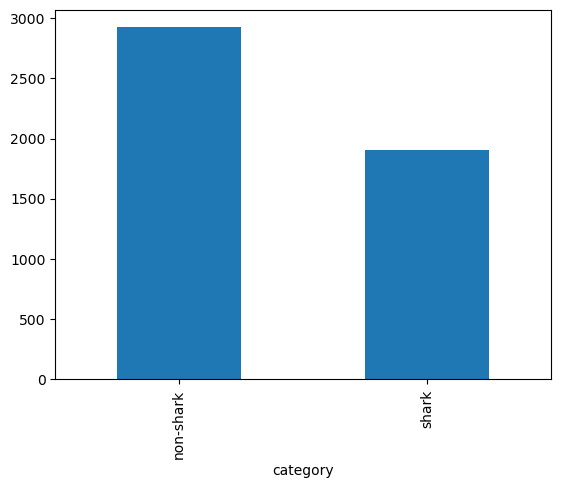

In [13]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

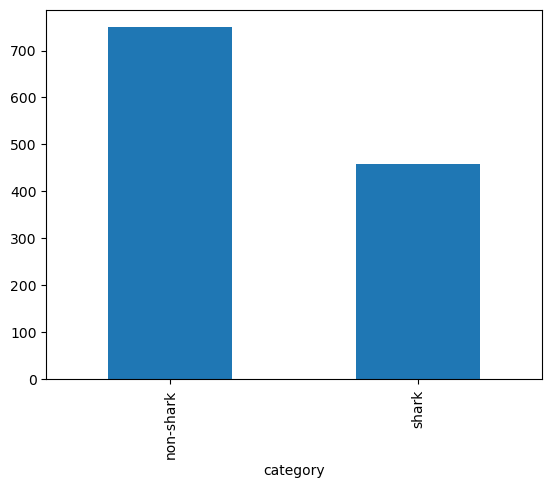

In [14]:
validate_df['category'].value_counts().plot.bar()

In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./images/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4831 validated image filenames belonging to 2 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./images/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1208 validated image filenames belonging to 2 classes.


In [18]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./images/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


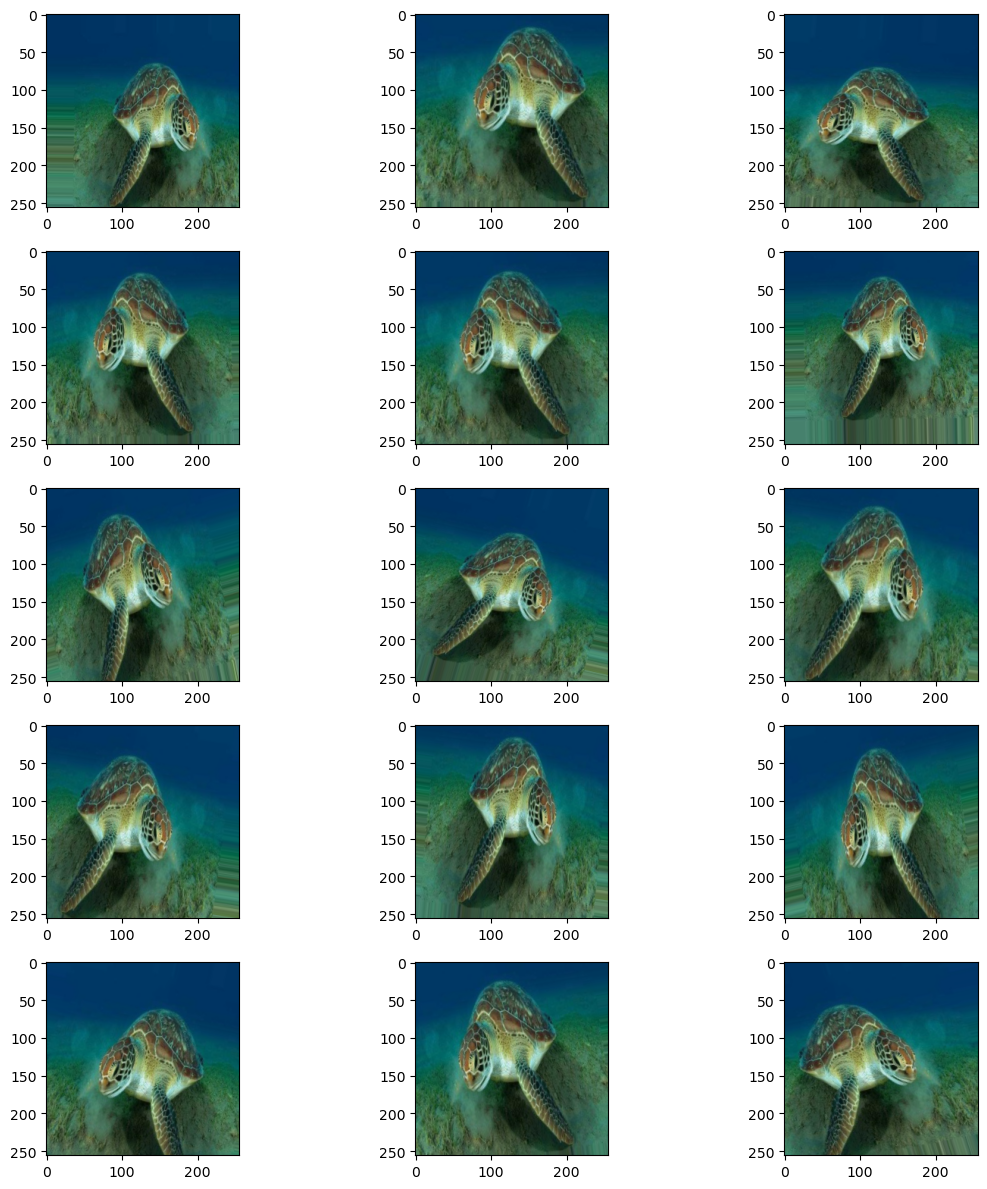

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\odonn\AppData\Local\Temp\ipykernel_41416\612699584.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
322/322 [==============================] - 470s 1s/step - loss: 0.8304 - accuracy: 0.6904 - val_loss: 1.1523 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 2/50
322/322 [==============================] - 405s 1s/step - loss: 0.5771 - accuracy: 0.7415 - val_loss: 0.8337 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 3/50
322/322 [==============================] - 404s 1s/step - loss: 0.5465 - accuracy: 0.7498 - val_loss: 0.4822 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 4/50
322/322 [==============================] - 403s 1s/step - loss: 0.5175 - accuracy: 0.7664 - val_loss: 0.5051 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 5/50
322/322 [==============================] - 402s 1s/step - loss: 0.5122 - accuracy: 0.7766 - val_loss: 0.5197 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 6/50
322/322 [==============================] - 403s 1s/step - loss: 0.5093 - accuracy: 0.7708 - val_loss: 0.5039 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 7/50
322/322 [==============================] - 406s 1s/st

In [ ]:
model.save_weights("initial_weights.h5")

NameError: name 'model' is not defined

In [22]:
model.load_weights("./board_code/models/initial_model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [23]:
test_filenames = os.listdir("./images/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [24]:
batch_size = 15

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./images/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1943 validated image filenames.


In [25]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\odonn\AppData\Local\Temp\ipykernel_19548\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [26]:
test_df['category'] = np.argmax(predict, axis=-1)

In [27]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [28]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

category
non-shark    984
shark        959
Name: count, dtype: int64


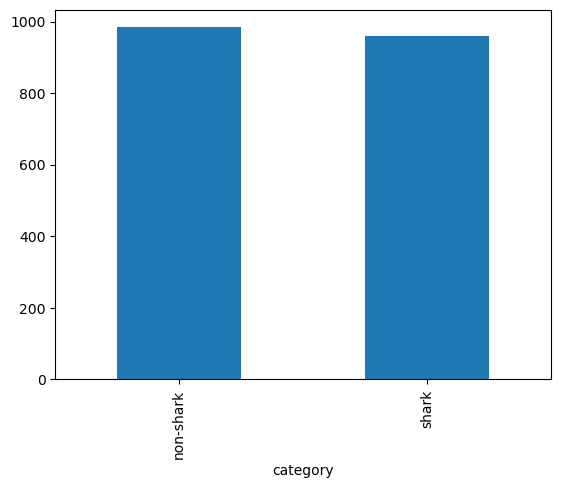

In [29]:
test_df['category'].value_counts().plot.bar()
print(test_df['category'].value_counts())

In [32]:
shark_correct = 0
shark_fp = 0
shark_total = 0
non_shark_correct = 0
non_shark_fp = 0
non_shark_total = 0
for i in range(len(test_df['category'])):
    # Predicted shark correctly
    if test_df['filename'][i].split('.')[0] in ('great_white_shark', 'hammerhead', 'tiger_shark') and test_df['category'][i] == 'shark':
        shark_correct += 1
        shark_total += 1
    elif test_df['filename'][i].split('.')[0] in ('great_white_shark', 'hammerhead', 'tiger_shark') and test_df['category'][i] == 'non-shark':
        shark_fp += 1
        shark_total += 1
    elif test_df['filename'][i].split('.')[0] not in ('great_white_shark', 'hammerhead', 'tiger_shark') and test_df['category'][i] == 'non-shark':
        non_shark_correct += 1
        non_shark_total += 1
    else:
        non_shark_fp += 1
        non_shark_total += 1

print('Sharks:', round(shark_correct/shark_total, 3) * 100, '%', sep='')
print('Non-sharks:', round(non_shark_correct/non_shark_total, 3) * 100)
print('Total:', round((shark_correct+non_shark_correct)/(shark_total+non_shark_total), 3) * 100)
print('')
tp = shark_correct + non_shark_correct
precision = tp / (tp + shark_fp)
recall = tp / (tp + non_shark_fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f'f1 score: {f1}')

Sharks:82.89999999999999%
Non-sharks: 78.0
Total: 80.2

f1 score: 0.8903483723586523
